# Week 1 Seminar

A/B experiment analysis

In [108]:
import glob
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

pd.set_option("display.precision", 3)

%matplotlib inline

In [109]:
experiment = "CUSTOM"

In [110]:
data = pd.concat([
    pd.read_json(data_path, lines=True)
    for data_path
    in glob.glob("../data-rec/data/*/data.json")
])

data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

In [111]:
data

,message,timestamp,user,track,time,latency,recommendation,experiments,treatment
0,next,2025-05-11 21:39:21.991,4329,31479,0.65,9.561e-04,31122.0,{'CUSTOM': 'C'},C
1,next,2025-05-11 21:39:21.994,4329,31122,0.55,5.600e-04,31479.0,{'CUSTOM': 'C'},C
2,next,2025-05-11 21:39:21.996,7554,27431,0.67,6.025e-04,27431.0,{'CUSTOM': 'C'},C
3,next,2025-05-11 21:39:21.999,4329,32170,0.22,3.734e-04,18590.0,{'CUSTOM': 'C'},C
4,next,2025-05-11 21:39:22.003,7554,12125,0.48,9.396e-04,24301.0,{'CUSTOM': 'C'},C
...,...,...,...,...,...,...,...,...,...
26877,next,2025-05-11 21:40:15.838,9350,6695,0.33,1.770e-03,48410.0,{'CUSTOM': 'T1'},T1
26878,last,2025-05-11 21:40:15.845,9350,47718,0.21,6.342e-05,NaN,{'CUSTOM': 'T1'},T1
26879,next,2025-05-11 21:40:15.851,9510,25365,0.29,4.630e-04,28231.0,{'CUSTOM': 'T1'},T1
26880,next,2025-05-11 21:40:15.855,9510,25365,0.00,4.590e-04,28231.0,{'CUSTOM': 'T1'},T1


In [112]:
data.groupby("treatment").count()

,message,timestamp,user,track,time,latency,recommendation,experiments
treatment,,,,,,,,
C,26946,26946,26946,26946,26946,26946,23565,26946
T1,26818,26818,26818,26818,26818,26818,23553,26818


## Visualize sessions

In [113]:
Session = namedtuple("Session", ["timestamp", "tracks", "time", "latency"])

def sessionize(user_data):
    sessions = []
    session = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if session is None:
            session = Session(row["timestamp"], 0, 0, 0)
        
        session = session._replace(
            tracks = session.tracks + 1, 
            time = session.time + row["time"],
            latency = session.latency + row["latency"] * 1000,
        )
        
        if row["message"] == "last":
            sessions.append(session._asdict())
            session = None
    return sessions

In [114]:
sessions = (
    data
    .groupby(["user", "treatment"])
    .apply(sessionize)
    .explode()
    .apply(pd.Series)
)

/var/folders/t7/36m0669n1h13dy9ll3s435v80000gn/T/ipykernel_76058/2717925121.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data


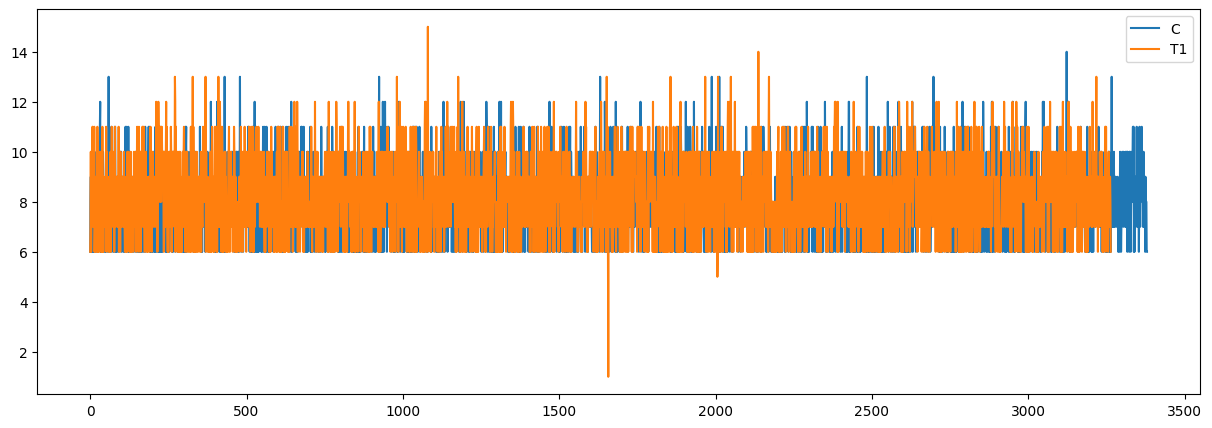

In [115]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["tracks"], label=treatment)
ax.legend()
pass

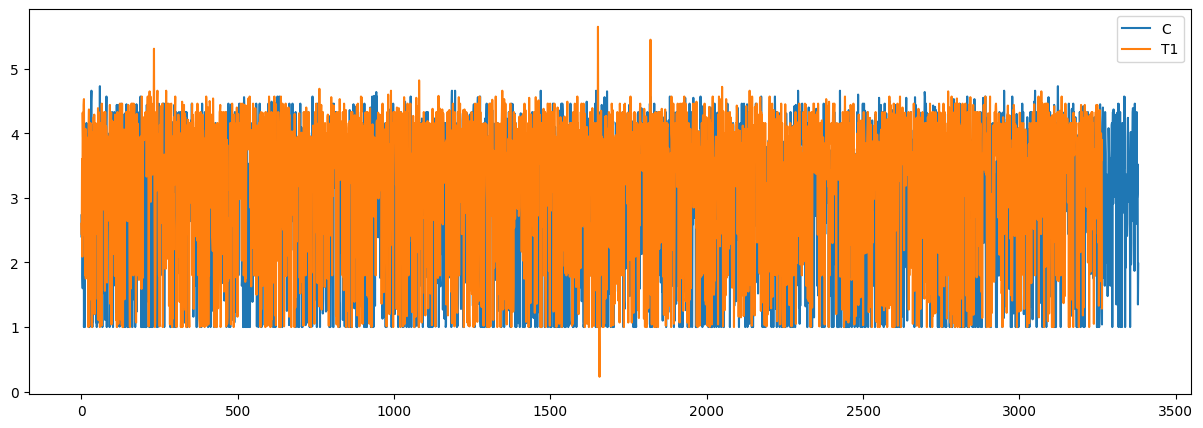

In [116]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["time"], label=treatment)
ax.legend()
pass

## Analyze the experiment

In [117]:
user_level_data = (
  sessions
    .reset_index()
    .groupby(["user", "treatment"])
    .agg(
        {
            "timestamp": "count",
            "tracks": "sum",
            "time": "sum",
            "latency": "sum"
        }
    )
)

user_level_data["sessions"] = user_level_data["timestamp"]
user_level_data["mean_request_latency"] = user_level_data["latency"] / user_level_data["tracks"]
user_level_data["mean_tracks_per_session"] = user_level_data["tracks"] / user_level_data["sessions"]
user_level_data["mean_time_per_session"] = user_level_data["time"] / user_level_data["sessions"]

metrics = [
    "time", 
    "sessions", 
    "mean_request_latency", 
    "mean_tracks_per_session", 
    "mean_time_per_session"
]

user_level_metrics = user_level_data[metrics].copy().reset_index()

In [118]:
treatment_level_metrics = (
    user_level_metrics
    .groupby("treatment")[metrics]
    .agg(["count", "mean", "var"])
)

In [119]:
def dof(n_0, n_1, s2_0, s2_1):
    numerator = (s2_0 / n_0 + s2_1 / n_1) * (s2_0 / n_0 + s2_1 / n_1)
    denominator = s2_0 * s2_0 / n_0 / n_0 / (n_0 - 1) + s2_1 * s2_1 / n_1 / n_1 / (n_1 - 1)
    return numerator / denominator


def ci(n_0, n_1, s2_0, s2_1, alpha=0.05):
    return ss.t.ppf(1 - alpha/2, dof(n_0, n_1, s2_0, s2_1)) * np.sqrt(s2_0 / n_0 + s2_1 / n_1)


effects = []

control = [data for treatment, data in treatment_level_metrics.iterrows() if treatment == "C"][0]

for treatment, row in treatment_level_metrics.iterrows():
    if treatment == "C":
        continue
    
    for metric in metrics:
        control_mean = control[metric]["mean"]
        treatment_mean = row[metric]["mean"]
        
        effect = treatment_mean - control_mean
        conf_int = ci(
            control[metric]["count"],
            row[metric]["count"],
            control[metric]["var"],
            row[metric]["var"],
        )
        effects.append({
            "treatment": treatment,
            "metric": metric,
            "control_mean": control_mean,
            "treatment_mean": treatment_mean,
            "effect": effect / control_mean * 100,
            "lower": (effect - conf_int) / control_mean * 100,
            "upper": (effect + conf_int) / control_mean * 100,
            "significant": (effect + conf_int) * (effect - conf_int) > 0
        })

In [120]:
def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

/var/folders/t7/36m0669n1h13dy9ll3s435v80000gn/T/ipykernel_76058/3627937693.py:9: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  pd.DataFrame(effects)[[


,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,9.584341,12.941807,6.226875,4.029871,4.416108,True
1,T1,sessions,1.460699,4.059904,-1.138505,1.358377,1.378219,False
3,T1,mean_tracks_per_session,3.063417,4.073188,2.053645,7.963707,8.207668,True
4,T1,mean_time_per_session,7.981775,9.956261,6.007289,2.963140,3.199651,True
2,T1,mean_request_latency,872.415977,906.332807,838.499148,0.236613,2.300864,True
